In [ ]:
# import os
from tqdm import trange
# import wandb

# import re
import gymnasium as gym
# from llamagym import Agent
import numpy as np
import d3rlpy
import pickle
import pandas as pd

# from gymnasium_env import BlackjackWrapper
import matplotlib.pyplot as plt
from atariari.benchmark.wrapper import AtariARIWrapper
from env.atari.represented_atari_game import GymCompatWrapper2

class InputParams:
    def __init__(self):
        self.env="RepresentedPong-v0"
        self.seed=1
        self.gpu=True

args=InputParams()
n_pretrain_eps = 499
n_online_eps = 4000-n_pretrain_eps

# d3rlpy supports both Gym and Gymnasium
env = GymCompatWrapper2(gym.make(args.env))
eval_env = GymCompatWrapper2(gym.make(args.env))

# fix seed
d3rlpy.seed(args.seed)
d3rlpy.envs.seed_env(env, args.seed)
d3rlpy.envs.seed_env(eval_env, args.seed)

/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.labels to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.labels` for environment variables or `env.get_wrapper_attr('labels')` that will search the reminding wrappers.
  logger.warn(
/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.spec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.spec` for environment variables or `env.get_wrapper_attr('spec')` that will search the reminding wrappers.
  logger.warn(
/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=0
  logger

## Offline pretraining

In [2]:
# # setup algorithm
# llama_dqn = d3rlpy.algos.DQNConfig(
#     batch_size=32,
#     learning_rate=6.25e-5,
#     ).create(device=args.gpu)

# with open('data/random_eps_5000.pkl', 'rb') as file:
# # with open('data/Qwen2.5-0.5B_eps_5000.pkl', 'rb') as file:
# # with open('data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', 'rb') as file:
#     dataset = pickle.load(file)

# # start offline training
# llama_dqn.fit(dataset, n_steps=1300) #Around 500 eps here

# with open('models/dqn_random_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_Qwen2.5-0.5B_eps_500.pkl', 'wb') as file:
# # with open('models/dqn_llama_eps_500.pkl', 'wb') as file:
#         pickle.dump(llama_dqn, file)

## Load pretrained model and online training

In [3]:
# def online_training(
#     env,
#     eval_env,
#     explorer=None,
#     model_path=None,
#     model=None,
#     data_path=None,
#     n_pretrain_eps=125,
#     limit=1000000,
#     n_steps=1050,
#     n_steps_per_epoch=300,
#     # update_interval=1,
#     cut_off_threshold=None,
#     gpu=True
# ):
#     # Load model with proper validation
#     if model_path:
#         with open(model_path, 'rb') as file:
#             dqn = pickle.load(file)
#     elif model:
#         dqn = model
#     else:
#         dqn = d3rlpy.algos.DQNConfig(
#             batch_size=32,
#             learning_rate=6.25e-5,
#             ).create(device=gpu)

#     # Initialize empty FIFO buffer
#     buffer = d3rlpy.dataset.ReplayBuffer(
#         buffer=d3rlpy.dataset.FIFOBuffer(limit=limit),
#         env=env,
#     )
    
#     # Load and merge offline data with type-checking
#     if data_path:
#         try:
#             # Load dataset with proper validation
#             with open(data_path, 'rb') as f:
#                 dataset = pickle.load(f)
            
#             # Verify dataset structure
#             if hasattr(dataset, 'episodes'):
#                 # Calculate safe episode count to load
#                 valid_episodes = min(n_pretrain_eps, len(dataset.episodes))
                
#                 # Append episodes with transition validation
#                 for episode in dataset.episodes[:valid_episodes]:
#                     if len(episode) > 0 and hasattr(episode, 'rewards'):
#                         buffer.append_episode(episode)
#                     else:
#                         print(f"Skipping invalid episode: {episode}")
#         except Exception as e:
#             print(f"Error loading dataset: {str(e)}")

#     # Configure training with safety checks
#     if buffer.transition_count == 0:
#         print("Empty buffer (just Online training)!")
#     dqn.fit_online(
#         env=env,
#         buffer=buffer,
#         explorer=explorer,
#         eval_env=eval_env,
#         n_steps=n_steps,
#         n_steps_per_epoch=n_steps_per_epoch,
#         # update_interval=update_interval,
#         # experiment_name="online_training",
#     )

#     # Extract rewards safely
#     rewards = []
#     for episode in buffer.episodes: # Only collect the online data
#         rewards.extend(episode.compute_return())
    
#     if cut_off_threshold:
#         start, end = cut_off_threshold
#         rewards = rewards[start:end]
#     return rewards

## Data collection

### Static/pretrain data

In [31]:
with open('data/RepresentedPong_Qwen2.5-0.5B-Instruct_Neps_500.pkl', 'rb') as file:
    Qwen_small_dataset = pickle.load(file)
    
# with open('data/SpaceInvaders_rand_Neps_2.pkl', 'rb') as file:
#     rand_dataset = pickle.load(file)
    
with open('data/RepresentedPong_Qwen2.5-7B-Instruct_Neps_500.pkl', 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)

#TODO: wrong
Qwen_small_rewards = []
for i in range(n_pretrain_eps):
    Qwen_small_rewards.append(Qwen_small_dataset.episodes[i].compute_return())
# rand_rewards = []
# for i in range(n_pretrain_eps):
#     rand_rewards.append(rand_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(n_pretrain_eps):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_small_rewards)
# rand_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(rand_rewards)
Qwen_7B_avg = np.ones(n_pretrain_eps + n_online_eps) * np.mean(Qwen_7B_rewards)

In [42]:
print(Qwen_7B_dataset.episodes[0].observations.shape)
print(Qwen_7B_dataset.episodes[0].rewards.shape)
# print(Qwen_7B_dataset.episodes[0].actions)
a = np.squeeze(Qwen_7B_dataset.episodes[0].actions)
print(a)

(382, 10)
(382, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
# Online data
# Read the CSV file
online_data = pd.read_csv("d3rlpy_logs/DoubleDQN_online_20250401200220/evaluation.csv")

# Extract the second and third columns as "steps" and "returns"
online_steps = online_data.iloc[:, 1].to_numpy()
online_eps = online_steps/500
online_eps = online_eps.astype(int)
online_returns = online_data.iloc[:, 2].to_numpy()

### Some optinal validation code

In [30]:
print(env.labels(), env.action_space, env.observation_space) #TODO: env.labels() missing the two new added features

from env.atari.SpaceInvaders_translator import ObsTranslator
translator = ObsTranslator()

c = 0
for e in Qwen_7B_dataset.episodes:
    if len(e.observations)>1:
        c+=1
    
print(f"# of valid episodes (>1 obs) in the dataset: {c}")

{'player_y': 109, 'player_x': 188, 'enemy_y': 22, 'enemy_x': 64, 'ball_x': 0, 'ball_y': 60, 'enemy_score': 0, 'player_score': 0} Discrete(6) Box(-inf, inf, (10,), float32)
# of valid episodes (>1 obs) in the dataset: 499


### Online data

In [6]:
# n_exp = 3
# # llama_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # Qwen_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # rand_LORO_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards_eps = np.zeros((n_pretrain_eps + n_online_eps, n_exp))
# # onl_rewards_eps_decay = np.zeros((n_pretrain_eps + n_online_eps, n_exp))

# n_steps = 1400
# n_pretrain_steps = 0

# onl_rewards = np.zeros((n_steps, n_exp))
# onl_rewards_eps = np.zeros((n_steps, n_exp))
# onl_rewards_eps_decay = np.zeros((n_steps, n_exp))

# # setup explorers
# const_explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.3)
# decay_explorer = d3rlpy.algos.LinearDecayEpsilonGreedy(
#     start_epsilon=1.0,
#     end_epsilon=0.1,
#     duration=10,
# )
# for i in range(n_exp):
#     # llama_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/meta-llama_Llama-2-7b-chat-hf_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
#     # Qwen_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/Qwen2.5-0.5B_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps)
#     # rand_LORO_rewards[n_pretrain_eps:,i] = online_training(env, eval_env, data_path='data/random_eps_5000.pkl', n_pretrain_eps=n_pretrain_eps) #list length 250 here
#     onl_rewards[:,i] = online_training(env, eval_env, n_steps=n_steps)
#     onl_rewards_eps[:,i] = online_training(env, eval_env, const_explorer, n_steps=n_steps)
#     onl_rewards_eps_decay[:,i] = online_training(env, eval_env, decay_explorer, n_steps=n_steps)

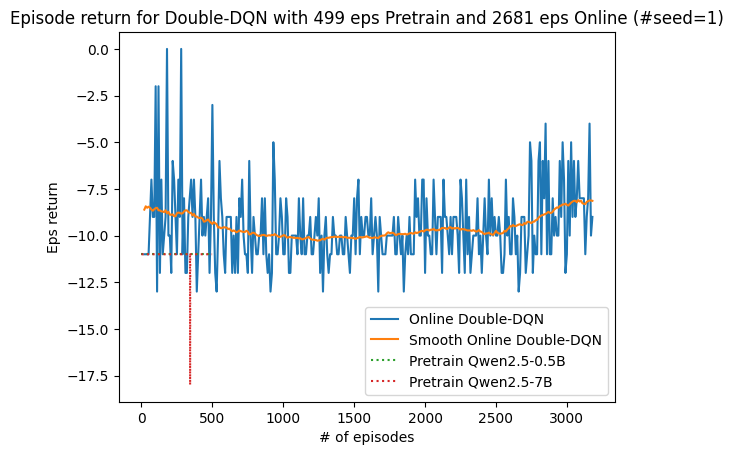

In [44]:
def moving_average(data, window_size):
    """Compute moving average using convolution."""
    window = np.ones(window_size) / window_size
    # return np.convolve(data, window, mode='valid')
    half_window = window_size // 2
    new_data = np.pad(data, (half_window, half_window), mode='reflect')  # Pad data to handle edges
    return np.convolve(new_data, window, mode='valid')

x = range(n_pretrain_eps + n_online_eps)
window_size = 51  # Must be an odd number
onl_y_smooth = moving_average(online_returns, window_size)

plt.plot(online_eps, online_returns, label='Online Double-DQN')
plt.plot(online_eps, onl_y_smooth, label='Smooth Online Double-DQN')

plt.plot(Qwen_small_rewards, label='Pretrain Qwen2.5-0.5B', linestyle=':')
# plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
plt.plot(Qwen_7B_rewards, label='Pretrain Qwen2.5-7B', linestyle=':')

# Customize the plot
plt.title(f'Episode return for Double-DQN with {n_pretrain_eps} eps Pretrain and {n_online_eps} eps Online (#seed={1})')
plt.xlabel('# of episodes')
plt.ylabel('Eps return')
# plt.ylim(-1, 4)
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()

# Plot (TODO: bug on eval here)

In [ ]:
# x = range(n_steps)
x = range(n_pretrain_eps + n_online_eps)

# mean_llama_LORO = np.mean(llama_LORO_rewards, axis = 1)
# std_llama_LORO = np.std(llama_LORO_rewards, axis = 1)
# mean_Qwen_LORO = np.mean(Qwen_LORO_rewards, axis = 1)
# std_Qwen_LORO = np.std(Qwen_LORO_rewards, axis = 1)
# mean_rand_LORO = np.mean(rand_LORO_rewards, axis = 1)
# std_rand_LORO = np.std(rand_LORO_rewards, axis = 1)
mean_onl = np.mean(onl_rewards, axis = 1)
std_onl = np.std(onl_rewards, axis = 1)
mean_onl_eps = np.mean(onl_rewards_eps, axis = 1)
std_onl_eps = np.std(onl_rewards_eps, axis = 1)
mean_onl_eps_decay = np.mean(onl_rewards_eps_decay, axis = 1)
std_onl_eps_decay = np.std(onl_rewards_eps_decay, axis = 1)

# mean_Qwen_LORO[:n_pretrain_eps] = Qwen_avg[:n_pretrain_eps]
# mean_llama_LORO[:n_pretrain_eps] = llama_avg[:n_pretrain_eps]
# mean_rand_LORO[:n_pretrain_eps] = rand_avg[:n_pretrain_eps]

# Smooth the data
window_size = 101  # Must be an odd number
# Qwen_LORO_y_smooth = moving_average(mean_Qwen_LORO, window_size)
# rand_LORO_y_smooth = moving_average(mean_rand_LORO, window_size)
# llama_LORO_y_smooth = moving_average(mean_llama_LORO, window_size)
onl_y_smooth = moving_average(mean_onl, window_size)
onl_y_eps_smooth = moving_average(mean_onl_eps, window_size)
onl_y_eps_decay_smooth = moving_average(mean_onl_eps_decay, window_size)

# std_onl = std_onl[window_size//2:-window_size//2 + 1]
# std_rand_LORO = std_rand_LORO[window_size//2:-window_size//2 + 1]
# std_Qwen_LORO = std_Qwen_LORO[window_size//2:-window_size//2 + 1]
# std_llama_LORO = std_llama_LORO[window_size//2:-window_size//2 + 1]
# x_smooth = x[window_size//2:-window_size//2 + 1]
x_smooth = x

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(onl_y_smooth, label='Online DQN')
plt.fill_between(x_smooth, onl_y_smooth-std_onl, onl_y_smooth+std_onl, alpha=0.5)
plt.plot(onl_y_eps_smooth, label='Online DQN const eps=0.3')
plt.fill_between(x_smooth, onl_y_eps_smooth-std_onl_eps, onl_y_eps_smooth+std_onl_eps, alpha=0.5)
plt.plot(onl_y_eps_decay_smooth, label='Online DQN decay eps')
plt.fill_between(x_smooth, onl_y_eps_decay_smooth-std_onl, onl_y_eps_decay_smooth+std_onl, alpha=0.5)
# plt.plot(Qwen_LORO_y_smooth, label='Finetune Qwen')
# plt.fill_between(x_smooth, Qwen_LORO_y_smooth-std_Qwen_LORO, Qwen_LORO_y_smooth+std_Qwen_LORO, alpha=0.5)
# plt.plot(rand_LORO_y_smooth, label='Finetune Rand')
# plt.fill_between(x_smooth, rand_LORO_y_smooth-std_rand_LORO, rand_LORO_y_smooth+std_rand_LORO, alpha=0.5)
# plt.plot(llama_LORO_y_smooth, label='Finetune Llama')
# plt.fill_between(x_smooth, llama_LORO_y_smooth-std_llama_LORO, llama_LORO_y_smooth+std_llama_LORO, alpha=0.5)

# plt.plot(Qwen_avg, label='Pretrain Qwen2.5-0.5B', linestyle=':')
# plt.plot(rand_avg, label='Pretrain Random', linestyle=':')
# plt.plot(llama_avg, label='Pretrain Llama', linestyle=':')

# Customize the plot
plt.title(f'Smoothed (w={window_size}) episode reward for DQN with {n_pretrain_steps} steps Pretrain and {n_steps} steps Online (#seed={n_exp})')
plt.xlabel('# of steps')
plt.ylabel('Eps reward')
plt.ylim(-1, 4)
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()